# **Exercise 1: MD simulations of LJ-Ag**

## *SVOLGIMENTO PUNTO 5*

---

## Consegna

### Parametri

In all simulations model Ag interatomic interactions using the LJ potential ($\varepsilon = 0.345$ eV and $\sigma = 2.644$ Å) with the cutoff radius at $R_C = 4.5$ Å. Assume $t_\text{th} = 3$ ps as thermalization time and use the simulation cell of 256-atoms (file `fcc100a256.txt` on the elearning page) unless stated differently. From point 3,

### Punto 1 ✅

Use a **sharp-cutoff** (no polynomial junction) approach and find the optimal timestep to perform a simulation from an initial temperature $T_\text{ini} = 50$ K. The optimal timestep is the maximum one such that $\frac{\delta E}{E} < 10^{−5}$. Consider the range 1, 25 fs and perform 5000 integration steps for each trial. Repeat the analysis for $T_\text{ini} = 500$ K and show that the criterion cannot be fulfilled however reducing the timestep.

#### Risultato

Risulta un $dt$ ottimale di 20 fs per T=50

### Punto 2 ✅

Implement a **7-degree polynomial** junction for $R_P < r < R_C$ with $R_P = 4.2$ Å. Use the coefficients $A, B, \dots, H$ for the 0th, 1st, ..., 7th degree term respectively, as provided in the file `poly7.py` on the elearning page. Adapt the definition of forces accordingly. Check that for $T_\text{ini} = 50$ K the simulation is consistent with the sharp-cutoff one and find the optimal timestep for $T_\text{ini} = 500$ K, $1000$ K and $2000$ K.

#### Risultato

La simulazione con giunzione polinomiale a T=50 è consistente a quella con shar-cutoff. La cosa interessante è che a 500K, usando la giunzione polinomiale, si riesce a scendere sotto il valore di tolleranza di $\frac{\delta E}{E} < 10^{−5}$

Risultano $dt$ ottimali di 20, 6, 4, 3 fs rispettivamente per T = 50, 500, 1000, 5000

### Punto 3 ✅

For the following points, implement a steepest-descent procedure to start the simulation from a minimum energy configuration (use C= 0.005 Å/𝑒𝑉 and stop when the maximum force falls below 0.001 𝑒𝑉/Å).


Using the optimal timesteps found in point 2, perform 10 𝑝𝑠 long simulations for $T_\text{ini} = 500$ K, $1000$ K and $2000$ K. Plot $\langle T \rangle$ as a function of $T_\text{ini}$ , check if the condition $\langle T \rangle = \frac{T_\text{ini}}{2}$ is
fulfilled and explain the result. Visualize the atomic trajectories of the atoms at the center of the
cluster and at the cube vertices for both the lowest and highest temperature and comment on
their difference.

#### Risultato

### Punto 4 ✅

Consider an infinite crystal slab (𝐿𝑥 = 𝐿𝑦 = 16.6416 Å) with free-surfaces in the 𝑧 direction. Add one adatom at the center of the upper surface, with 𝑧 coordinate set 2.4 Å above the maximum 𝑧 coordinate of the atoms in the cell. Perform a 300 𝑝𝑠 long simulation starting from the minimized configuration. Set 𝑇𝑖𝑛𝑖 such to achieve an equilibrium temperature 𝑇 = 850 ± 30 𝐾 and use an appropriate timestep. Trace the trajectory of the adatom over time.

#### Risultato

### Punto 5 🛠️

Repeat the analysis of point 4 using a (111)-oriented cell from the file fcc111a336+1.txt on the elearning page with 𝐿𝑥 = 𝐿𝑦 = 20.3817 Å and compare the results for the two orientations. Is the adatom diffusion likely to happen at room temperature on one or both surfaces on the same time interval?

#### Risultato

A temperatura ambiente T=300K l'adatom sulla superficie della cella orientata (100) resta praticamente immobile per tutta la durata della simulazione; quello sulla superficie della cella orientata (111) invece si sposta in due o tre siti. In quest'ultima allora la probabilità di diffusione è più alta, spiegabile con la quantità di vicini che la superficie offre all'atomo su di essa depositato. Nel caso (100) l'adatom è posto al centro, tra due atomi, quindi subito si sposta al centro di quattro atomi e lì rimane. Nel caso (111) gli atomi massimi che può avere intorno sono tre, il che rende la sua permanenza in un sito molto meno probabile.

---

## Svolgimento PUNTO 5

### 0) Importazioni e dati

In [1]:
import numpy as np
from CMS.MolecularDynamics.CrystalStructure import CrystalStructure as Crystal
from CMS.MolecularDynamics.CrystalDynamics import CrystalDynamics, CrystalDynamicsResult

In [2]:
# Nome del file (numero di atomi da studiare: 336 + 1 adatom)
filename = '../../../data/fcc111a336+1.txt'

#### Dati globali

In [3]:
# boundaries della cella da studiare (crystal slab)
pbc = [20.3817, 20.3817, 203_817]  # in Å (z enorme (> Lx*10_000))

# temperature da studiare
temperature = [300, 850] # in K

# massa atomica dell'atomo considerato (argento)
silver_mass = 108

# time step ottimale per 1000K
time_step = {
    300: 6e-15,
    850: 4e-15 
}

# il numero di step è dato dal tempo totale (300ps) diviso il time step
tempo_totale = 300e-12
n_steps = {T: int(tempo_totale / time_step[T]) for T in temperature}

# tempo di termalizzazione (ogni valore precedente va buttato)
t_th = 3e-12

### 1) Simulazione di 300ps a T = 850 K e T = 300 K

In [4]:
from CMS.MolecularDynamics.io import AtomTracker, XYZwriter
# Inizializzo il tracker per l'atomo aggiunto (ultimo atomo)
adatom_tracker_unbounded = {
    850: AtomTracker(index=-1, output_file='output/1_5/Esercizio1_5_850/adatom_track_unbounded.txt'), 
    300: AtomTracker(index=-1, output_file='output/1_5/Esercizio1_5_300/adatom_track_unbounded.txt')
}
adatom_tracker_periodic = {
    850: AtomTracker(index=-1, output_file='output/1_5/Esercizio1_5_850/adatom_track_periodic.txt', pbc_option='periodic'), 
    300: AtomTracker(index=-1, output_file='output/1_5/Esercizio1_5_300/adatom_track_periodic.txt', pbc_option='periodic')
}
# Inizializzo lo scrittore XYZ per salvare la dinamica
xyz_writers = {
    850: XYZwriter(output_folder='output/1_5/Esercizio1_5_850/', dt=time_step[850], dump_interval=200, pbc_option='periodic'), 
    300: XYZwriter(output_folder='output/1_5/Esercizio1_5_300/', dt=time_step[300], dump_interval=200)
}   

In [5]:
result_list = []

In [6]:
for T in temperature:
    print(f"🚀 Avvio simulazione a T={T} K")    
    
    # Raccolgo le energie medie e le dev std
    # Inizializzo il cristallo dal file minimizzato con steepest-descent
    cristallo = Crystal.from_file(filename)
    # Setto il raggio di cutoff E la giunzione polinomiale
    cristallo.set_R_C(4.5)
    cristallo.set_R_P(4.2)
    cristallo.set_R_V(5.0) # n.b.: R_V > R_C e va settato DOPO R_C
    # Setto le condizioni al contorno periodiche (vanno settate DOPO R_C)
    cristallo.set_pbc(pbc)

    simulazione = CrystalDynamics(cristallo, 
                        atomic_mass=silver_mass, 
                        dt=time_step[T], 
                        temp_ini=T, 
                        atom_tracker=[adatom_tracker_unbounded[T], adatom_tracker_periodic[T]], 
                        xyz_writer= xyz_writers[T])  
    simulazione.set_seed(126543)

    # stavolta output True per visualizzare con ovito
    result: CrystalDynamicsResult = simulazione.run_dynamics(n_steps=n_steps[T], 
                                                            t_th=t_th,
                                                            rescale_velocity=True,
                                                            debug=False)
    
    result_list.append(result)

🚀 Avvio simulazione a T=300 K
🚀 Avvio simulazione a T=850 K


### 2) Analisi e plot

#### 2.1) Alcuni dati della simulazione

In [7]:
for r, temp in zip(result_list, temperature):
    print(f"Risultati per T={temp} K")
    r.summary()

Risultati per T=300 K
Simulation Result:
 - Duration: 300.00 ps
 - Mean Temp: 300.91 ± 9.27 K
 - Mean Energy: -681.91 ± 0.01 eV

Risultati per T=850 K
Simulation Result:
 - Duration: 300.00 ps
 - Mean Temp: 854.28 ± 27.54 K
 - Mean Energy: -633.74 ± 0.01 eV



#### 2.2) Plot x,y di adatom

In [8]:
import matplotlib.pyplot as plt

Provo a plottare anche un fotogramma della superficie. Non è rappresentativo, poiché non se ne vede l'evoluzione nel tempo, ma può essere carino.

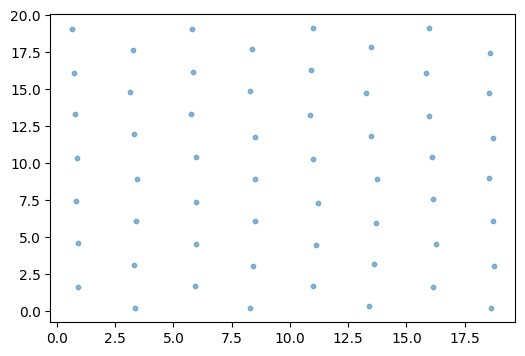

In [ ]:
pos = cristallo.positions[:-1]  # tutte le posizioni tranne l'ultimo atomo (adatom)
z_max = np.max(pos[:, 2]) # [:, 2] prende la terza colonna (Z)
# Poiché gli atomi vibrano, prendiamo tutti quelli entro ~0.5 Angstrom dal max
tolleranza = 2
mask_superficie = pos[:, 2] > (z_max - tolleranza)

# 5. Estraggo gli indici o le posizioni
atomi_superficiali = pos[mask_superficie]
indici_superficiali = np.where(mask_superficie)[0]

plt.figure(figsize=(6, 4))
for sup in [atomi_superficiali]: 
    plt.scatter(sup[:, 0], sup[:, 1], s=10, alpha=0.5)

plt.show()

#### Adatom non confinato

In [19]:
# data = np.loadtxt("output/dynamics/steps100000~dt3e-15~T1700~Ag~257/adatom_track.txt", skiprows=1, delimiter="\t")
data1 = np.loadtxt("output/1_5/Esercizio1_5_850/adatom_track_unbounded.txt", skiprows=2, delimiter="\t")
x1 = data1[:, 1]
y1 = data1[:, 2]

data2 = np.loadtxt("output/1_5/Esercizio1_5_300/adatom_track_unbounded.txt", skiprows=2, delimiter="\t")
x2 = data2[:, 1]
y2 = data2[:, 2]

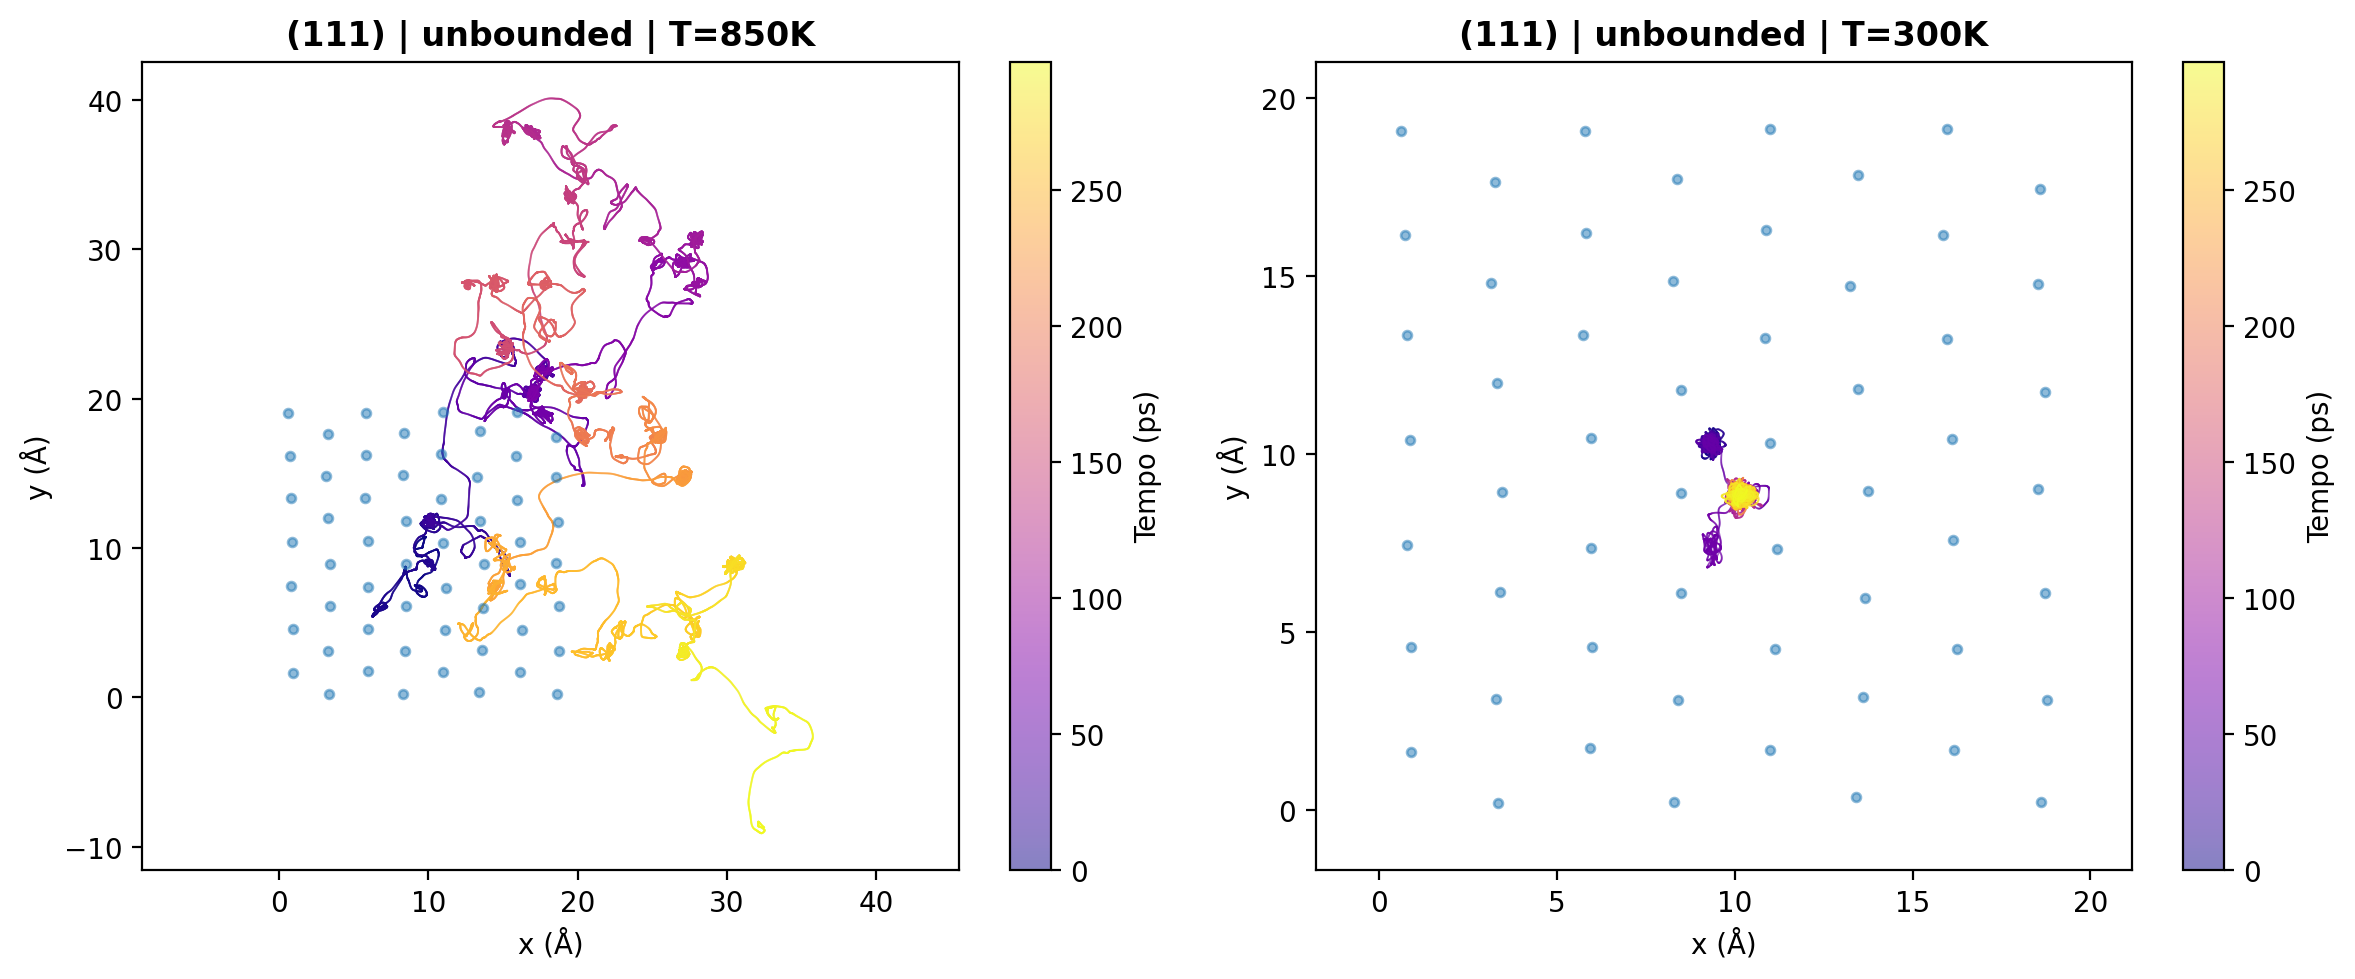

In [21]:
# metto due grafici per 850K e 300K uno accanto all'altro 
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=200)

# Creiamo un array di indici per il colore
time_indices1 = np.arange(len(x1)) * (time_step[850] * 1e12)  # Convertiamo gli step temporali in picosecondi

# Usiamo scatter
ax[0].scatter(x1, y1, c=time_indices1, cmap='plasma', s=0.5, linewidth=0, alpha=0.5)

ax[0].set_xlabel('x (Å)')
ax[0].set_ylabel('y (Å)')
ax[0].set_title("(111) | unbounded | T=850K", fontweight='bold')
ax[0].axis('equal') # Per non distorcere la geometria

for sup in [atomi_superficiali]: 
    ax[0].scatter(sup[:, 0], sup[:, 1], s=10, alpha=0.5)

cbar1 = plt.colorbar(ax[0].collections[0], ax=ax[0])
cbar1.set_label('Tempo (ps)')

# Creiamo un array di indici per il colore
time_indices2 = np.arange(len(x2)) * (time_step[300] * 1e12)  # Convertiamo gli step temporali in picosecondi

# Usiamo scatter. 
# c=time_indices dice di usare l'indice per il colore
# s=0.5 rende i punti piccolissimi
# linewidth=0 toglie il bordo ai punti per evitare che si sovrappongano troppo
ax[1].scatter(x2, y2, c=time_indices2, cmap='plasma', s=0.5, linewidth=0, alpha=0.5)

ax[1].set_xlabel('x (Å)')
ax[1].set_ylabel('y (Å)')
ax[1].set_title("(111) | unbounded | T=300K", fontweight='bold')
ax[1].axis('equal') # Per non distorcere la geometria

for sup in [atomi_superficiali]: 
    ax[1].scatter(sup[:, 0], sup[:, 1], s=10, alpha=0.5)

cbar2 = plt.colorbar(ax[1].collections[0], ax=ax[1])
cbar2.set_label('Tempo (ps)')

plt.tight_layout()
plt.show()

#### Adatom confinato

In [23]:
data3 = np.loadtxt("output/1_5/Esercizio1_5_850/adatom_track_periodic.txt", skiprows=2, delimiter="\t")
x3 = data3[:, 1]
y3 = data3[:, 2]

data4 = np.loadtxt("output/1_5/Esercizio1_5_300/adatom_track_periodic.txt", skiprows=2, delimiter="\t")
x4 = data4[:, 1]
y4 = data4[:, 2]

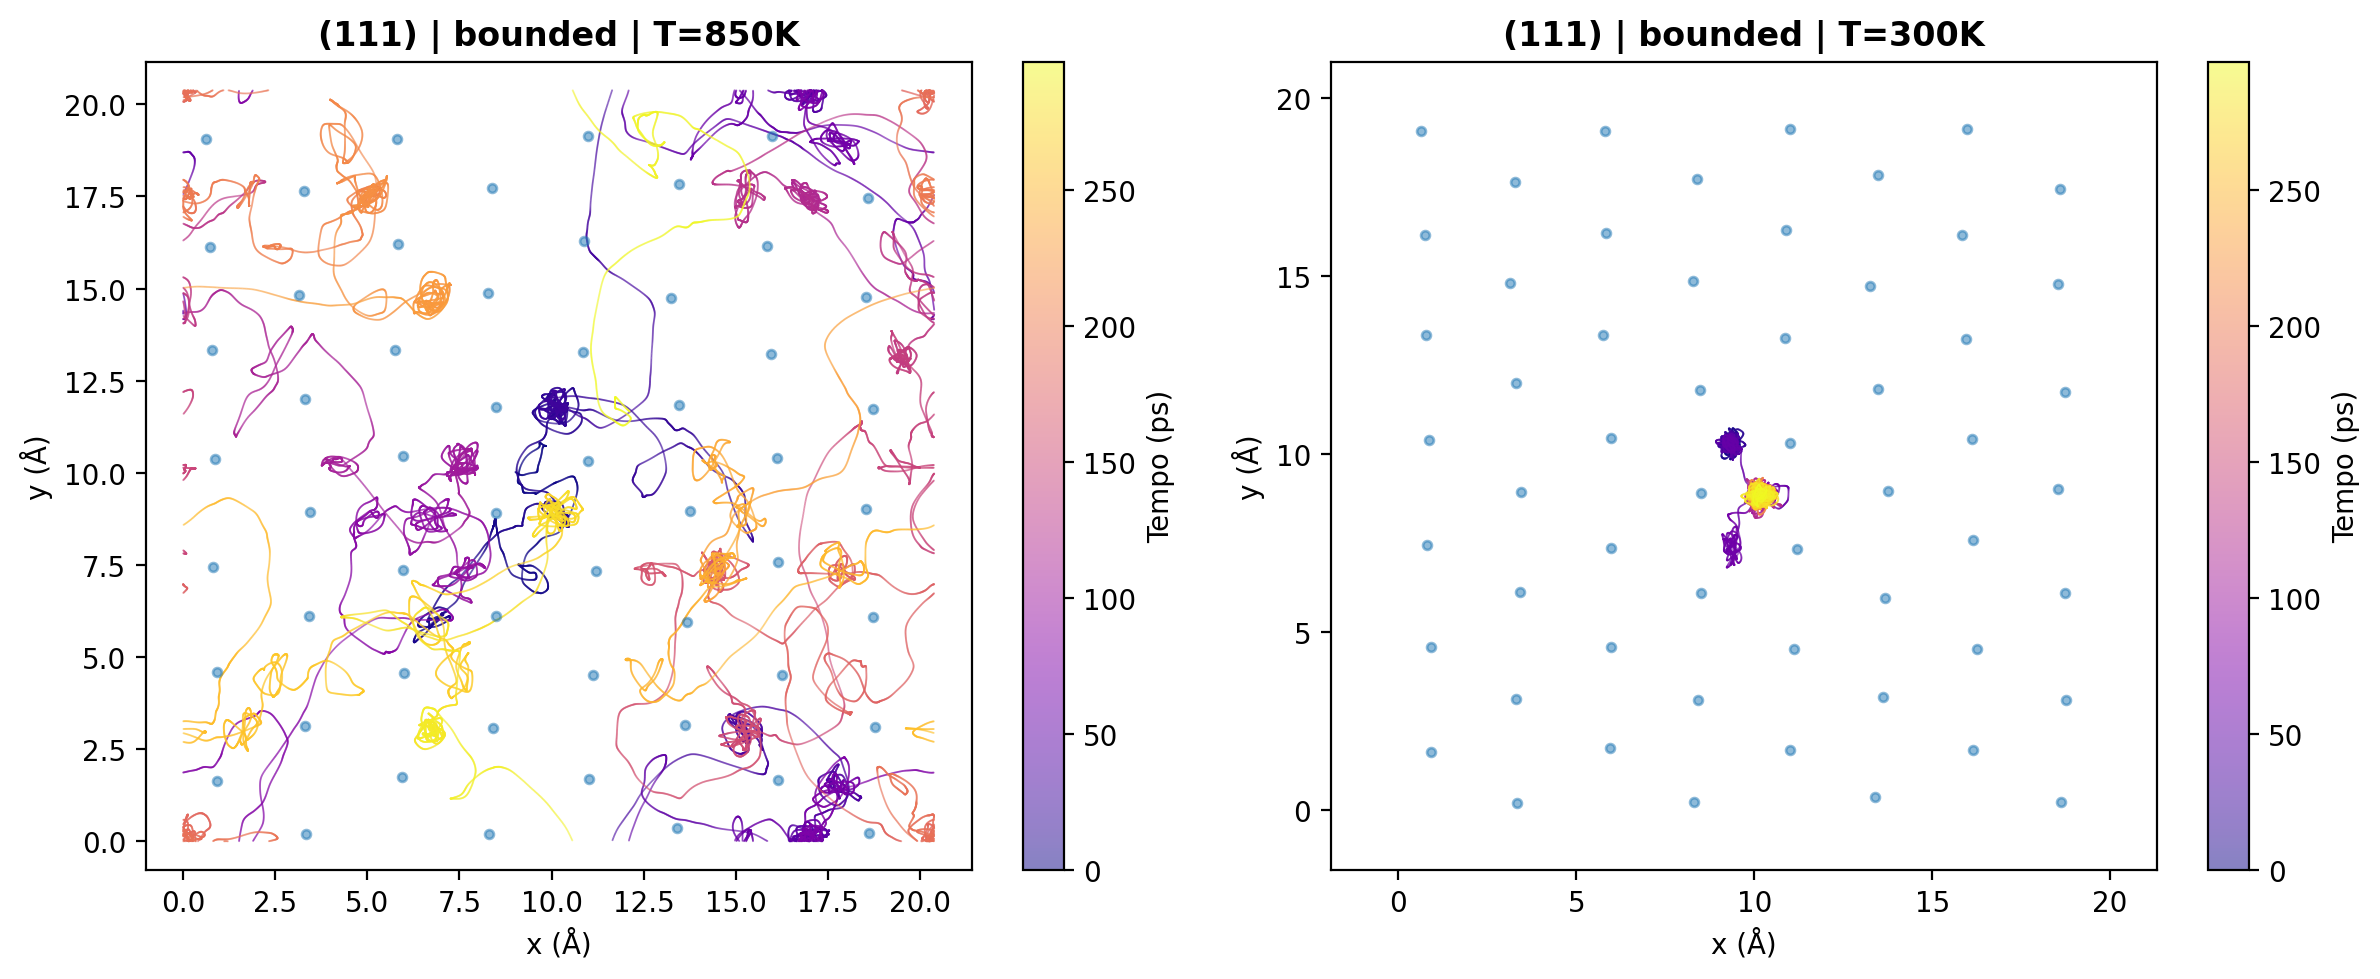

In [24]:
# metto due grafici per 850K e 300K uno accanto all'altro 
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=200)

# Creiamo un array di indici per il colore
time_indices1 = np.arange(len(x3)) * (time_step[850] * 1e12)  # Convertiamo gli step temporali in picosecondi

# Usiamo scatter
ax[0].scatter(x3, y3, c=time_indices1, cmap='plasma', s=0.5, linewidth=0, alpha=0.5)

ax[0].set_xlabel('x (Å)')
ax[0].set_ylabel('y (Å)')
ax[0].set_title("(111) | bounded | T=850K", fontweight='bold')
ax[0].axis('equal') # Per non distorcere la geometria

for sup in [atomi_superficiali]: 
    ax[0].scatter(sup[:, 0], sup[:, 1], s=10, alpha=0.5)

cbar1 = plt.colorbar(ax[0].collections[0], ax=ax[0])
cbar1.set_label('Tempo (ps)')

# Creiamo un array di indici per il colore
time_indices2 = np.arange(len(x4)) * (time_step[300] * 1e12)  # Convertiamo gli step temporali in picosecondi

# Usiamo scatter. 
# c=time_indices dice di usare l'indice per il colore
# s=0.5 rende i punti piccolissimi
# linewidth=0 toglie il bordo ai punti per evitare che si sovrappongano troppo
ax[1].scatter(x4, y4, c=time_indices2, cmap='plasma', s=0.5, linewidth=0, alpha=0.5)

ax[1].set_xlabel('x (Å)')
ax[1].set_ylabel('y (Å)')
ax[1].set_title("(111) | bounded | T=300K", fontweight='bold')
ax[1].axis('equal') # Per non distorcere la geometria

for sup in [atomi_superficiali]: 
    ax[1].scatter(sup[:, 0], sup[:, 1], s=10, alpha=0.5)

cbar2 = plt.colorbar(ax[1].collections[0], ax=ax[1])
cbar2.set_label('Tempo (ps)')

plt.tight_layout()
plt.show()